In [40]:
import pandas as pd
import numpy as np
import cv2

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, accuracy_score, confusion_matrix

from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

from sklearn import neighbors
from sklearn.model_selection import cross_val_score
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier


from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.utils import shuffle
import json

import seaborn as sns  # spezielle Graphikdarstellungen


In [9]:
data = pd.read_pickle('./data/images_df_numerical.pkl')
classes = data["Species"].unique()
number_of_classes = classes.size

# Alleiniges undersampling wird keinen Sinn machen, da wir extrem wenig Datenpunkte overall haben
def resample(resampler) -> tuple[np.array, np.array]:
    X, y = data['data'], data['Species']
    X, y = np.stack(X).astype(np.uint8), y.to_numpy().astype(np.uint8)
    X_resampled, y_resampled = resampler.fit_resample(X, y)

    print(f"{resampler}: ", pd.Series(y_resampled, dtype=pd.UInt8Dtype()).value_counts())

    X_resampled, y_resampled = shuffle(X_resampled, y_resampled, random_state=1)

    return X_resampled, y_resampled

# oversampling
adasyn = ADASYN()

X, y = resample(adasyn)




image_size = X[0].size
samples = X.size
with open("./data/meta.json","r") as file:  # get metadata for images from file generated from import nb
    image_meta = json.load(file) 
image_shape = (image_meta['h'],image_meta['w'],image_meta['c']) # hwc
print("Image has shape", image_shape)
# normalize to 0-1
X = X / 255.
X = X.reshape((-1,) + image_shape)

ADASYN():  4    1958
0    1940
1    1935
3    1932
5    1930
2    1925
Name: count, dtype: Int64
Image has shape (65, 100, 3)


### Laden der Daten

## Visualisieren der Anzahl

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8,6))
unique, counts = np.unique(y, return_counts=True)
plt.bar(unique, counts, color="skyblue")

plt.title("Verteilung der klassen der Feldermäuse")
plt.xlabel("Klasse")
plt.ylabel("Häufigkeit")

plt.show()

## Split Train and Test Data + Flatten

In [18]:
def split_and_flatten_data(X, y, test_size=0.25):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=1)

    X_train = np.array(X_train)
    X_test = np.array(X_test)

    y_train = np.array(y_train)
    y_test = np.array(y_test)

    #Flatten der Daten

    X_train_flatten = X_train.reshape(len(X_train), -1)
    X_test_flatten = X_test.reshape(len(X_test), -1)

    return  X_train_flatten, X_test_flatten, y_train, y_test

## Erstellen eines einfachen Decison Tree 

In [19]:
from sklearn.tree import DecisionTreeClassifier
#bat_tree = DecisionTreeClassifier(max_depth=10, criterion="entropy")

def fit_tree(X_train, y_train, max_depth=1, criterion="gini", min_samples_leaf=4,):

    bat_tree=DecisionTreeClassifier(max_depth=max_depth, criterion=criterion)
    bat_tree.fit(X_train,y_train)
    return bat_tree

def evaluate_model(model, X_train, y_train, X_test, y_test,):
    #predictions
    y_hat_tr = model.predict(X_train)
    y_hat_test = model.predict(X_test)

    #bat_score = accuracy_score(y_hat_test, y_test)
    bat_tr_score=model.score(X_train, y_train, sample_weight=None)
    bat_test_score=model.score(X_test, y_test, sample_weight=None)

      # print("bat_score", bat_score)
      # print('Trainings-Score:',bat_tr_score,'; Test-Score:',bat_test_score)
      # print('Confusion matrix:\n', confusion_matrix(y_test, y_hat_test))
      # print(classification_report(y_test, y_hat_test,digits=3))

    return  bat_tr_score, bat_test_score


## Erstellen eines einfachen Decison Trees
Im Folgendem werden verschiedene Baum-Tiefen getestet. Zudem wird als "Maß der Unreinheit" Gini und Entropie gentutzt.

In [26]:

max_depth_values = range(1,10)
criterion_values = ["gini", "entropy"]

train_acc_dict = {}
test_acc_dict = {}

for depth in max_depth_values:
    for criterion in criterion_values:
        # Trainings- und Testdaten aufteilen
        X_train, X_test, y_train, y_test = split_and_flatten_data(X, y, test_size=0.25)
        
        # Modell trainieren
        model = fit_tree(X_train, y_train, max_depth=depth, criterion=criterion)
        
        # Modell evaluieren
        train_acc, test_acc = evaluate_model(model, X_train, y_train, X_test, y_test)
        
        # Ergebnisse speichern
        train_acc_dict[(depth, criterion)] = train_acc
        test_acc_dict[(depth, criterion)] = test_acc

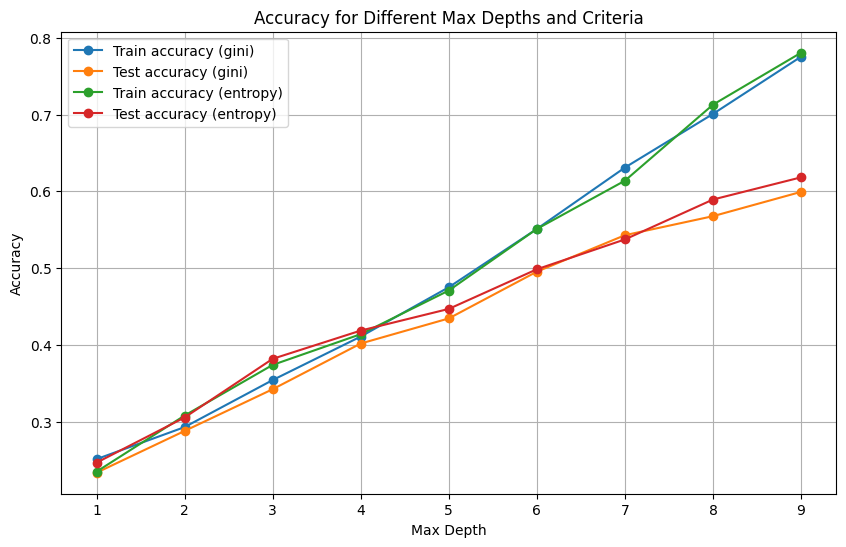

In [109]:
import matplotlib.pyplot as plt
import numpy as np

# Hier nehmen wir an, dass train_acc_dict und test_acc_dict bereits definiert und gefüllt sind

depths = range(1, 10)
criterion_values = ["gini", "entropy"]

# Extrahiere die Test- und Trainingsgenauigkeiten für die verschiedenen Kriterien
train_accs_gini = [train_acc_dict[(depth, 'gini')] for depth in depths]
test_accs_gini = [test_acc_dict[(depth, 'gini')] for depth in depths]

train_accs_entropy = [train_acc_dict[(depth, 'entropy')] for depth in depths]
test_accs_entropy = [test_acc_dict[(depth, 'entropy')] for depth in depths]

# Plotte die Ergebnisse
plt.figure(figsize=(10, 6))
plt.plot(depths, train_accs_gini, marker='o', label='Train accuracy (gini)')
plt.plot(depths, test_accs_gini, marker='o', label='Test accuracy (gini)')
plt.plot(depths, train_accs_entropy, marker='o', label='Train accuracy (entropy)')
plt.plot(depths, test_accs_entropy, marker='o', label='Test accuracy (entropy)')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('Accuracy for Different Max Depths and Criteria')
plt.xticks(np.arange(1, 10, step=1))  # X-Achsenbeschriftung für jeden Max Depth
plt.legend()
plt.grid(True)
plt.show()


## Random Forest
Vorbereiten der Daten, sodass diese in der Richtigen Form sind

In [50]:
# Laden der Daten
data = pd.read_pickle('./data/images_df_numerical.pkl')
classes = data["Species"].unique()
number_of_classes = classes.size

# Alleiniges undersampling wird keinen Sinn machen, da wir extrem wenig Datenpunkte overall haben
def resample(resampler) -> tuple[np.array, np.array]:
    X, y = data['data'], data['Species']
    X, y = np.stack(X).astype(np.uint8), y.to_numpy().astype(np.uint8)
    X_resampled, y_resampled = resampler.fit_resample(X, y)

    print(f"{resampler}: ", pd.Series(y_resampled, dtype=pd.UInt8Dtype()).value_counts())

    X_resampled, y_resampled = shuffle(X_resampled, y_resampled, random_state=1)

    return X_resampled, y_resampled

# oversampling
adasyn = ADASYN()

X, y = resample(adasyn)


image_size = X[0].size
samples = X.size
with open("./data/meta.json","r") as file:  # get metadata for images from file generated from import nb
    image_meta = json.load(file) 
image_shape = (image_meta['h'],image_meta['w'],image_meta['c']) # hwc
print("Image has shape", image_shape)
# normalize to 0-1
X = X / 255.
X = X.reshape((-1,) + image_shape)

X_train, X_test, y_train, y_test = split_and_flatten_data(X,y, 0.25)


ADASYN():  4    1958
0    1940
1    1935
3    1932
5    1930
2    1925
Name: count, dtype: Int64
Image has shape (65, 100, 3)


## Random Forest (Bagging)
Folgender Code berechnet Modele mit verschiedenen Parametern

In [126]:
from sklearn.ensemble import RandomForestClassifier

i_estimators = range(1, 500, 25)
leaf_nodes = range(2,32,2)


random_train_acc_dict1 = {}
random_test_acc_dict1 = {}

for estimators in i_estimators:
    for nodes in leaf_nodes:
        rnd_clf = RandomForestClassifier(n_estimators=estimators, max_leaf_nodes=nodes, n_jobs=-1)
        rnd_clf.fit(X_train, y_train)

        y_pred_rf = rnd_clf.predict(X_test)

        train_acc, test_acc = evaluate_model(rnd_clf, X_train, y_train, X_test, y_test)
        random_train_acc_dict1[(estimators,nodes)] = train_acc
        random_test_acc_dict1[(estimators, nodes)] = test_acc

        print(f"Number of estimators: {estimators}")
        print("Train accuracy:", train_acc)
        print("Test accuracy:", test_acc)
        print("-" * 20)


Number of estimators: 1
Train accuracy: 0.251061388410786
Test accuracy: 0.24440619621342513
--------------------
Number of estimators: 1
Train accuracy: 0.28537005163511187
Test accuracy: 0.2705679862306368
--------------------
Number of estimators: 1
Train accuracy: 0.32759609868043604
Test accuracy: 0.2998278829604131
--------------------
Number of estimators: 1
Train accuracy: 0.34503729202524386
Test accuracy: 0.32598967297762477
--------------------
Number of estimators: 1
Train accuracy: 0.33034997131382676
Test accuracy: 0.32358003442340794
--------------------
Number of estimators: 1
Train accuracy: 0.3602983362019507
Test accuracy: 0.35008605851979346
--------------------
Number of estimators: 1
Train accuracy: 0.3761331038439472
Test accuracy: 0.3624784853700516
--------------------
Number of estimators: 1
Train accuracy: 0.37165806081468733
Test accuracy: 0.3672977624784854
--------------------
Number of estimators: 1
Train accuracy: 0.3962134251290878
Test accuracy: 0.3814

### Auswertung Test und Training
Darstellung der Test und Trainingsfehler

{(1, 2): 0.251061388410786, (1, 4): 0.28537005163511187, (1, 6): 0.32759609868043604, (1, 8): 0.34503729202524386, (1, 10): 0.33034997131382676, (1, 12): 0.3602983362019507, (1, 14): 0.3761331038439472, (1, 16): 0.37165806081468733, (1, 18): 0.3962134251290878, (1, 20): 0.38909925415949514, (1, 22): 0.3966724039013196, (1, 24): 0.4091795754446357, (1, 26): 0.41881812966150317, (1, 28): 0.4111302352266208, (1, 30): 0.4209982788296041, (26, 2): 0.2625358577165806, (26, 4): 0.39093516924842225, (26, 6): 0.43293172690763054, (26, 8): 0.4621916236374068, (26, 10): 0.49145152036718304, (26, 12): 0.5222030981067126, (26, 14): 0.5405622489959839, (26, 16): 0.5503155479059093, (26, 18): 0.5725760183591508, (26, 20): 0.5741824440619622, (26, 22): 0.5857716580608147, (26, 24): 0.5928858290304073, (26, 26): 0.6100975329890993, (26, 28): 0.6121629374641423, (26, 30): 0.6254733218588641, (51, 2): 0.2699942627653471, (51, 4): 0.4041308089500861, (51, 6): 0.4359150889271371, (51, 8): 0.468158347676419

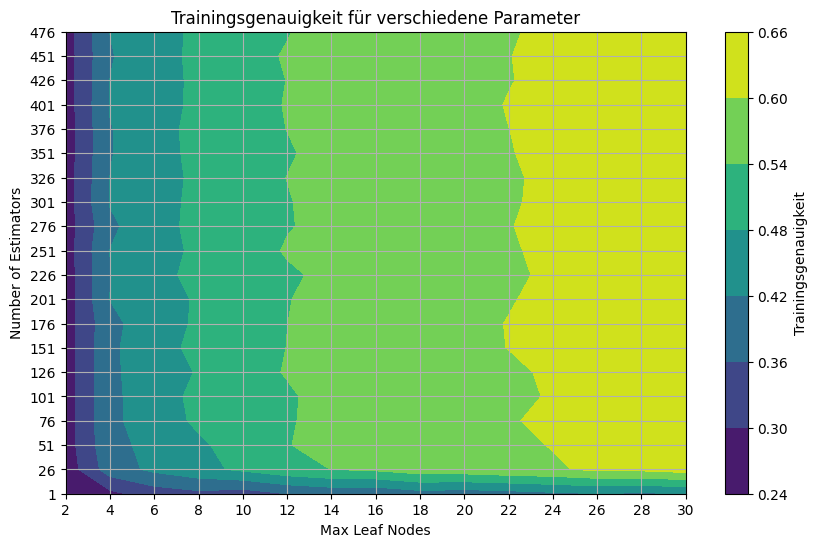

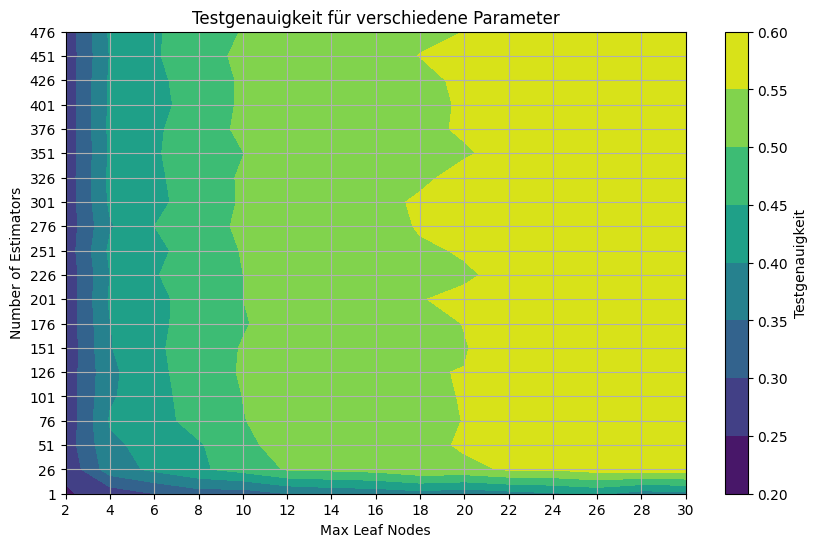

In [127]:
print(random_train_acc_dict1)
print()
print()
print(random_test_acc_dict1)

# Um die Ergebnisse plotten zu können, müssen wir die Daten in Arrays umwandeln
estimators_list = list(i_estimators)
leaf_nodes_list = list(leaf_nodes)

train_accuracy_array = np.array([[random_train_acc_dict1[(est, node)] for node in leaf_nodes_list] for est in estimators_list])
test_accuracy_array = np.array([[random_test_acc_dict1[(est, node)] for node in leaf_nodes_list] for est in estimators_list])

# Erstelle ein Konturlinien-Diagramm für Trainingsgenauigkeit
plt.figure(figsize=(10, 6))
contour = plt.contourf(leaf_nodes_list, estimators_list, train_accuracy_array, cmap='viridis')
plt.colorbar(contour, label='Trainingsgenauigkeit')
plt.xlabel('Max Leaf Nodes')
plt.ylabel('Number of Estimators')
plt.title('Trainingsgenauigkeit für verschiedene Parameter')
plt.xticks(leaf_nodes_list)
plt.yticks(estimators_list)
plt.grid(visible=True)
plt.show()

# Erstelle ein Konturlinien-Diagramm für Testgenauigkeit
plt.figure(figsize=(10, 6))
contour = plt.contourf(leaf_nodes_list, estimators_list, test_accuracy_array, cmap='viridis')
plt.colorbar(contour, label='Testgenauigkeit')
plt.xlabel('Max Leaf Nodes')
plt.ylabel('Number of Estimators')
plt.title('Testgenauigkeit für verschiedene Parameter')
plt.xticks(leaf_nodes_list)
plt.yticks(estimators_list)
plt.grid(visible=True)
plt.show()



## Extra Trees -  Extremly Randomized Trees

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

i_estimators = range(1, 500, 25)
leaf_nodes = range(2,32,2)


extra_train_acc_dict = {}
extra_test_acc_dict = {}

for estimators in i_estimators:
    for nodes in leaf_nodes:
        rnd_clf = ExtraTreesClassifier(n_estimators=estimators, max_leaf_nodes=nodes, n_jobs=-1)
        rnd_clf.fit(X_train, y_train)

        y_pred_rf = rnd_clf.predict(X_test)

        train_acc, test_acc = evaluate_model(rnd_clf, X_train, y_train, X_test, y_test)
        extra_train_acc_dict[(estimators,nodes)] = train_acc
        extra_test_acc_dict[(estimators, nodes)] = test_acc

        print(f"Number of estimators: {estimators}")
        print("Train accuracy:", train_acc)
        print("Test accuracy:", test_acc)
        print("-" * 20)


### Auswertung Test und Training

In [100]:
print("Train", extra_train_acc_dict)
print("Test", extra_test_acc_dict)

print("-"*30)
# Finde den maximalen Wert und den dazugehörigen Schlüssel im Trainings-Dictionary
max_train_value = max(extra_train_acc_dict.values())
max_train_key = max(extra_train_acc_dict, key=extra_train_acc_dict.get)

print("Maximaler Wert für Training:", max_train_value)
print("Dazu gehörige Trainings-Parameter:", max_train_key)

# Versuche, den Testfehler für den Schlüssel 176 im Test-Dictionary zu erhalten, oder gib 30 zurück, falls nicht vorhanden
test_error_176 = extra_test_acc_dict.get((176, 30))
print("Testfehler für den Schlüssel 176 (falls vorhanden):", test_error_176)

print("-"*30)
max_train_value = max(extra_test_acc_dict.values())
max_train_key = max(extra_test_acc_dict, key=extra_test_acc_dict.get)

print("Maximaler Wert für Training:", max_train_value)
print("Dazu gehörige Trainings-Parameter:", max_train_key)

Train {(1, 2): 0.22857142857142856, (1, 4): 0.2761904761904762, (1, 6): 0.2836488812392427, (1, 8): 0.3070567986230637, (1, 10): 0.30590935169248423, (1, 12): 0.31210556511761334, (1, 14): 0.34411933448078025, (1, 16): 0.3449225473321859, (1, 18): 0.336201950659782, (1, 20): 0.34974182444061963, (1, 22): 0.36305220883534134, (1, 24): 0.36419965576592084, (1, 26): 0.3693631669535284, (1, 28): 0.3833620195065978, (1, 30): 0.3667240390131956, (26, 2): 0.2806655192197361, (26, 4): 0.37888697647733793, (26, 6): 0.3815261044176707, (26, 8): 0.4196213425129088, (26, 10): 0.4555364314400459, (26, 12): 0.4612736660929432, (26, 14): 0.4619621342512909, (26, 16): 0.47802639127940333, (26, 18): 0.4822719449225473, (26, 20): 0.5077452667814114, (26, 22): 0.517154331612163, (26, 24): 0.5281698221457257, (26, 26): 0.5410212277682157, (26, 28): 0.5301204819277109, (26, 30): 0.542512908777969, (51, 2): 0.2683878370625359, (51, 4): 0.36121629374641423, (51, 6): 0.4092943201376936, (51, 8): 0.45266781411

{(1, 2): 0.22857142857142856, (1, 4): 0.2761904761904762, (1, 6): 0.2836488812392427, (1, 8): 0.3070567986230637, (1, 10): 0.30590935169248423, (1, 12): 0.31210556511761334, (1, 14): 0.34411933448078025, (1, 16): 0.3449225473321859, (1, 18): 0.336201950659782, (1, 20): 0.34974182444061963, (1, 22): 0.36305220883534134, (1, 24): 0.36419965576592084, (1, 26): 0.3693631669535284, (1, 28): 0.3833620195065978, (1, 30): 0.3667240390131956, (26, 2): 0.2806655192197361, (26, 4): 0.37888697647733793, (26, 6): 0.3815261044176707, (26, 8): 0.4196213425129088, (26, 10): 0.4555364314400459, (26, 12): 0.4612736660929432, (26, 14): 0.4619621342512909, (26, 16): 0.47802639127940333, (26, 18): 0.4822719449225473, (26, 20): 0.5077452667814114, (26, 22): 0.517154331612163, (26, 24): 0.5281698221457257, (26, 26): 0.5410212277682157, (26, 28): 0.5301204819277109, (26, 30): 0.542512908777969, (51, 2): 0.2683878370625359, (51, 4): 0.36121629374641423, (51, 6): 0.4092943201376936, (51, 8): 0.45266781411359724

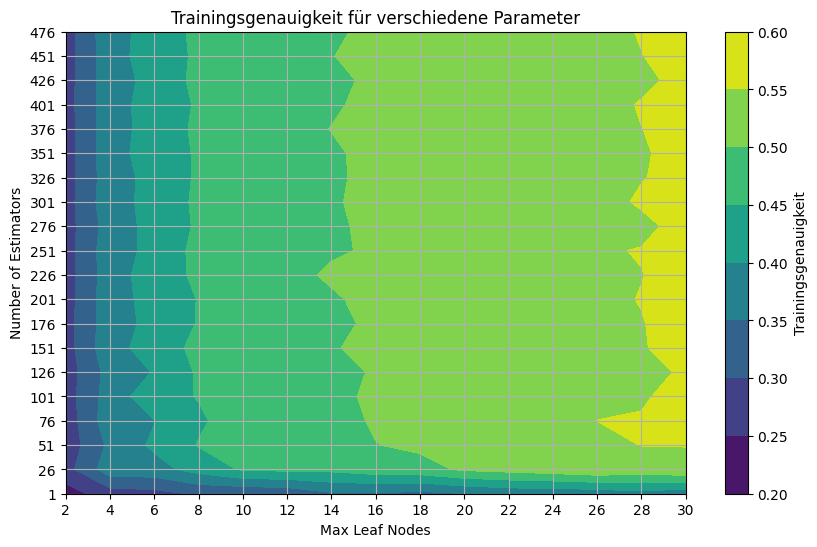

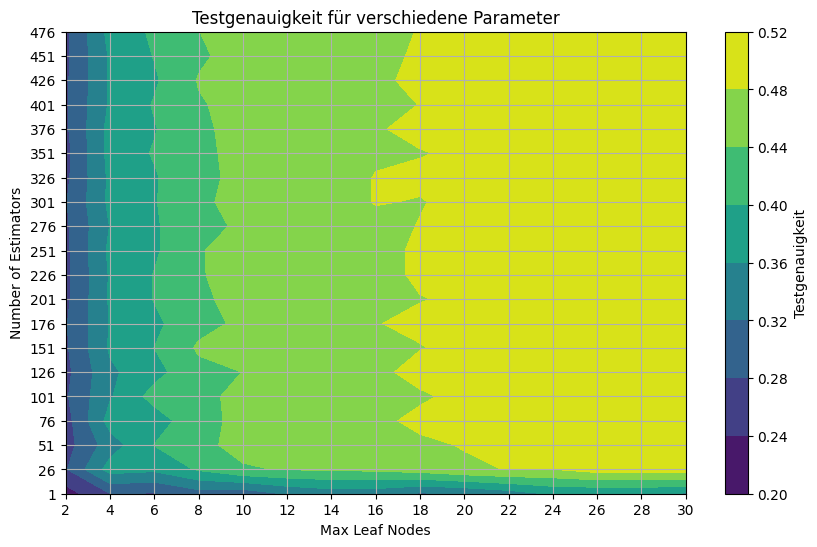

In [128]:
print(extra_train_acc_dict)
print()
print()
print(extra_test_acc_dict)

# Um die Ergebnisse plotten zu können, müssen wir die Daten in Arrays umwandeln
estimators_list = list(i_estimators)
leaf_nodes_list = list(leaf_nodes)

train_accuracy_array = np.array([[extra_train_acc_dict[(est, node)] for node in leaf_nodes_list] for est in estimators_list])
test_accuracy_array = np.array([[extra_test_acc_dict[(est, node)] for node in leaf_nodes_list] for est in estimators_list])

# Erstelle ein Konturlinien-Diagramm für Trainingsgenauigkeit
plt.figure(figsize=(10, 6))
contour = plt.contourf(leaf_nodes_list, estimators_list, train_accuracy_array, cmap='viridis')
plt.colorbar(contour, label='Trainingsgenauigkeit')
plt.xlabel('Max Leaf Nodes')
plt.ylabel('Number of Estimators')
plt.title('Trainingsgenauigkeit für verschiedene Parameter')
plt.xticks(leaf_nodes_list)
plt.yticks(estimators_list)
plt.grid(visible=True)
plt.show()

# Erstelle ein Konturlinien-Diagramm für Testgenauigkeit
plt.figure(figsize=(10, 6))
contour = plt.contourf(leaf_nodes_list, estimators_list, test_accuracy_array, cmap='viridis')
plt.colorbar(contour, label='Testgenauigkeit')
plt.xlabel('Max Leaf Nodes')
plt.ylabel('Number of Estimators')
plt.title('Testgenauigkeit für verschiedene Parameter')
plt.xticks(leaf_nodes_list)
plt.yticks(estimators_list)
plt.grid(visible=True)
plt.show()



### Darstellung der besten 10 Test und Trainingsfehler

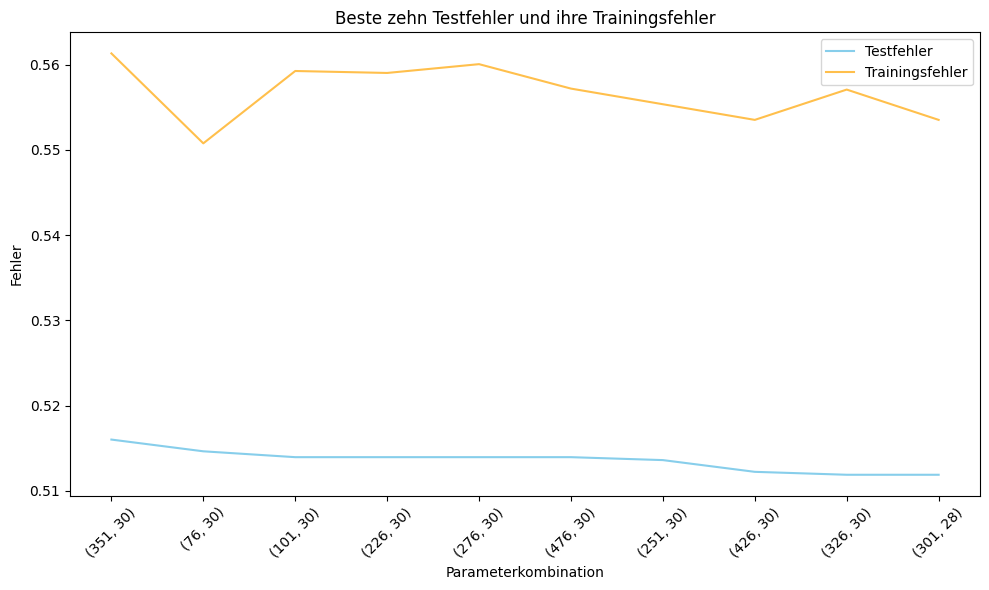

In [129]:
import matplotlib.pyplot as plt

# Annahme: Die Dictionaries extra_train_acc_dict und extra_test_acc_dict sind vorhanden und enthalten Trainings- und Testgenauigkeiten

sorted_dict_train = {k: v for k, v in sorted(extra_train_acc_dict.items(), key=lambda item: item[1], reverse=True)}
sorted_dict_test = {k: v for k, v in sorted(extra_test_acc_dict.items(), key=lambda item: item[1], reverse=True)}

common_keys = set(extra_train_acc_dict.keys()) & set(extra_test_acc_dict.keys())

common_elements = {key: (extra_train_acc_dict[key], extra_test_acc_dict[key]) for key in common_keys}

# Sortiere die gemeinsamen Elemente nach den Testfehlern in absteigender Reihenfolge und wähle die besten zehn aus
sorted_common_elements = sorted(common_elements.items(), key=lambda x: x[1][1], reverse=True)[:10]

best_test_errors = []
best_train_errors = []
best_params = []

for key, value in sorted_common_elements:
    best_params.append(str(key))
    best_train_errors.append(value[0])
    best_test_errors.append(value[1])

# Erstelle ein Balkendiagramm für die besten zehn Testfehler und ihre Trainingsfehler
plt.figure(figsize=(10, 6))
plt.plot(best_params, best_test_errors, color='skyblue', label='Testfehler')
plt.plot(best_params, best_train_errors, color='orange', alpha=0.7, label='Trainingsfehler')

plt.xlabel('Parameterkombination')
plt.ylabel('Fehler')
plt.title('Beste zehn Testfehler und ihre Trainingsfehler')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


# Boosting
## 1. AdaBoost

In [132]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200, algorithm="SAMME.R", learning_rate=0.7)
ada_clf.fit(X_train, y_train)


In [ ]:
ada_clf_train = ada_clf.predict(X_train)
ada_clf_test = ada_clf.predict(X_test)

train_accuracy = accuracy_score(y_train, ada_clf_train)
test_accuracy = accuracy_score(y_test, ada_clf_test)

print("Train accuary_score", train_accuracy)
print("Test accuracy_score", test_accuracy)

Train accuary_score 0.29156626506024097
Test accuracy_score 0.2719449225473322


## 2. Gardient Boosting

#### Laden und Spliten der Daten

In [ ]:
# Laden der Daten
data = pd.read_pickle('./data/images_df_numerical.pkl')
classes = data["Species"].unique()
number_of_classes = classes.size

# Alleiniges undersampling wird keinen Sinn machen, da wir extrem wenig Datenpunkte overall haben
def resample(resampler) -> tuple[np.array, np.array]:
    X, y = data['data'], data['Species']
    X, y = np.stack(X).astype(np.uint8), y.to_numpy().astype(np.uint8)
    X_resampled, y_resampled = resampler.fit_resample(X, y)

    print(f"{resampler}: ", pd.Series(y_resampled, dtype=pd.UInt8Dtype()).value_counts())

    X_resampled, y_resampled = shuffle(X_resampled, y_resampled, random_state=1)

    return X_resampled, y_resampled

# oversampling
adasyn = ADASYN()

X, y = resample(adasyn)


image_size = X[0].size
samples = X.size
with open("./data/meta.json","r") as file:  # get metadata for images from file generated from import nb
    image_meta = json.load(file) 
image_shape = (image_meta['h'],image_meta['w'],image_meta['c']) # hwc
print("Image has shape", image_shape)
# normalize to 0-1
X = X / 255.
X = X.reshape((-1,) + image_shape)

X_train, X_test, y_train, y_test = split_and_flatten_data(X,y, 0.25)


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import mean_squared_error


gbrt = GradientBoostingClassifier(max:depth=2, n_estimators=120)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_test, y_pred) for y_pred in gbrt.staged_predict(X_test)]
bst_n_estimators = np.argmin(errors)

gbrt_best = GradientBoostingClassifier(max_depth=2, n_estimators=bst_n_estimators)
gbrt_best.fit(X_train, y_train)



### Early Stopping

In [ ]:
gbrt = GradientBoostingClassifier(max_depth=2, warm_start=True)

min_val_error = float("inf")
error_going_up = 0

for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_test)
    test_error = mean_squared_error(y_test, y_pred)
    if test_error < min_val_error:
        min_val_error = test_error:
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break   #Early Stopping

        

